## Pyro, Bayesian analysis, and attempt on BCRF (Qi et al 2005)

In [46]:
import pyro
from pyro.distributions import Normal, Uniform
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO, EmpiricalMarginal
from pyro.infer.mcmc import MCMC, NUTS
from pyro.optim import Adam

import torch
import torch.nn as nn

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

In [2]:
DATA_URL = "https://d2fefpcigoriu7.cloudfront.net/datasets/rugged_data.csv"
data = pd.read_csv(DATA_URL, encoding="ISO-8859-1")
df = data[["cont_africa", "rugged", "rgdppc_2000"]]
df = df[np.isfinite(df.rgdppc_2000)]
df["rgdppc_2000"] = np.log(df["rgdppc_2000"])

In [3]:
data = torch.tensor(df.values, dtype=torch.float)
x_data, y_data = data[:, :-1], data[:, -1]

In [57]:
def model(x_data, y_data):
    n = len(x_data)

    # w, b, sigma parameter is outside of plate, independent of N
    weight = pyro.sample("w", dist.Normal(torch.zeros(1, 2), torch.ones(1, 2)))
    bias = pyro.sample("b", dist.Normal(torch.tensor([[0.]]), torch.tensor([[100.]])))
    sigma = pyro.sample("epsilon", Uniform(0., 10.))

    with pyro.plate("map", n):
        mu = (x_data[:, 0] * weight[0][0] + x_data[:, 1] * weight[0][1] + bias).squeeze(1)
        yhat = pyro.sample("yhat", Normal(mu, sigma), obs=y_data)
        return yhat

## stochastic Variational Inference with mean-field approx (spherical gaussian)

In [58]:
from pyro.contrib.autoguide import AutoDiagonalNormal
mean_field_guide = AutoDiagonalNormal(model)

# inject callables into SVI instantiation
svi = SVI(model, mean_field_guide, Adam({"lr": 0.03}), loss=Trace_ELBO(), num_samples=1000)

In [59]:
pyro.clear_param_store()
for j in range(2000):
    loss = svi.step(x_data, y_data)
    if j % 500 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss / len(data)))

[iteration 0001] loss: 3.6504
[iteration 0501] loss: 2.2643
[iteration 1001] loss: 1.4705
[iteration 1501] loss: 1.4959


In [60]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))

auto_loc tensor([-1.4550, -0.0358,  9.0282, -2.2280], requires_grad=True)
auto_scale tensor([0.1447, 0.0398, 0.0765, 0.0825], grad_fn=<AddBackward0>)


## No-U-turn Sampler

In [61]:
pyro.clear_param_store()

nuts = NUTS(model)
sampler = MCMC(nuts,
               num_samples=1000,
               num_chains=1,
               # burn-in
               warmup_steps=100)
traces = sampler.run(x_data, y_data)

Sample: 100%|██████████| 1100/1100 [00:36<00:00, 40.53it/s, step size=2.60e-03, acc. rate=0.978]


In [63]:
posteriors = traces.marginal(["w", "b", "epsilon"])

In [72]:
a = posteriors.empirical["epsilon"]

In [64]:
def get_marginal(traces, sites):
    return EmpiricalMarginal(traces, sites)._get_samples_and_weights()[0].detach().cpu().numpy()

In [99]:
posterior_weight = posteriors.empirical["w"]
posterior_bias = posteriors.empirical["b"]
posterior_epsilon = posteriors.empirical["epsilon"]

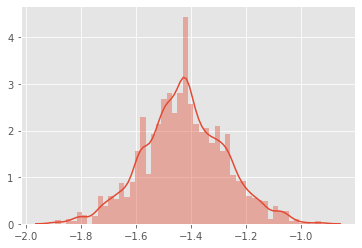

In [114]:
sns.distplot(posterior_weight.sample((10000, )).squeeze(1)[:, 0])

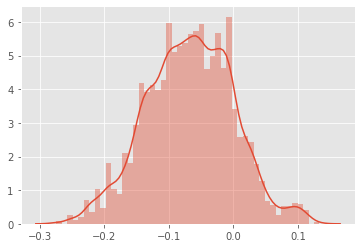

In [115]:
sns.distplot(posterior_weight.sample((10000, )).squeeze(1)[:, 1])

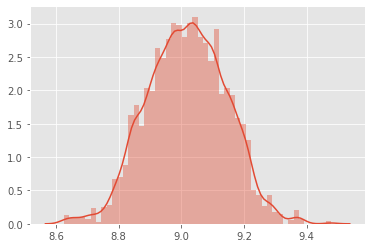

In [90]:
sns.distplot(posterior_bias.sample((10000, )))

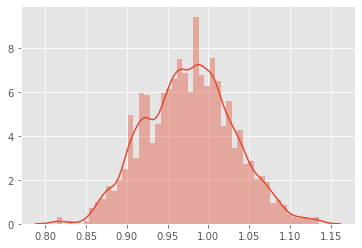

In [116]:
sns.distplot(posterior_epsilon.sample((10000, )))